In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [2]:
import numpy as np
import ujson

from collections import Counter, defaultdict
from itertools import islice
from boltons.iterutils import windowed
from tqdm import tqdm_notebook
from glob import glob

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [3]:
class Corpus:
    
    def __init__(self, pattern, skim=None):
        self.pattern = pattern
        self.skim = skim
        
    def lines(self):
        for path in glob(self.pattern):
            with open(path) as fh:
                for line in fh:
                    yield line.strip()

    def abstracts(self):
        lines = self.lines()
        if self.skim:
            lines = islice(lines, self.skim)
        for line in tqdm_notebook(lines, total=self.skim):
            raw = ujson.loads(line)
            yield Abstract.from_raw(raw)
            
    def xy(self, vocab):
        for abstract in self.abstracts():
            yield from abstract.xy(vocab)
            
    def ngram_counts(self, n):
        counts = defaultdict(lambda: 0)
        for ab in self.abstracts():
            for sent in ab.sentences:
                for ngram in sent.ngrams(n):
                    counts[ngram] += 1
        return Counter(counts)
            
    def most_common_ngrams(self, n, depth):
        counts = self.ngram_counts(n)
        return set([k for k, _ in counts.most_common(depth)])

In [4]:
class Abstract:
    
    @classmethod
    def from_raw(cls, raw):
        return cls([Sentence(s['token']) for s in raw['sentences']])
    
    def __init__(self, sentences):
        self.sentences = sentences
    
    def xy(self, vocab):
        for i, sent in enumerate(self.sentences):
            x = sent.features(vocab)
            y = i / (len(self.sentences)-1)
            yield x, y

In [5]:
class Sentence:
    
    def __init__(self, tokens):
        self.tokens = tokens
    
    def ngrams(self, n=1):
        for ng in windowed(self.tokens, n):
            yield '_'.join(ng)
            
    def ngram_counts(self, vocab, maxn=3):
        for n in range(1, maxn+1):
            counts = Counter(self.ngrams(n))
            for k, v in counts.items():
                if k in vocab:
                    yield f'_{k}', v
                    
    def word_count(self):
        return len(self.tokens)
                
    def _features(self, vocab):
        yield from self.ngram_counts(vocab)
        yield 'word_count', self.word_count()
        
    def features(self, vocab):
        return dict(self._features(vocab))

In [42]:
train = Corpus('/Users/dclure/Projects/sent-order/data/train.json/*.json', 500000)

In [43]:
vocab = (
    train.most_common_ngrams(1, 3000) |
    train.most_common_ngrams(2, 2000) |
    train.most_common_ngrams(3, 1000)
)

HBox(children=(IntProgress(value=0, max=500000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500000), HTML(value='')))

In [44]:
len(vocab)

6000

In [45]:
dv = DictVectorizer()

In [46]:
train_x, train_y = zip(*train.xy(vocab))

HBox(children=(IntProgress(value=0, max=500000), HTML(value='')))

In [47]:
train_x = dv.fit_transform(train_x)

In [48]:
train_x

<2688235x6001 sparse matrix of type '<class 'numpy.float64'>'
	with 81750558 stored elements in Compressed Sparse Row format>

In [49]:
model = LinearRegression()

In [50]:
fit = model.fit(train_x, train_y)

In [51]:
test = Corpus('/Users/dclure/Projects/sent-order/data/test.json/*.json', 100000)

In [52]:
test_x, test_y = zip(*test.xy(vocab))

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

In [53]:
test_x = dv.transform(test_x)

In [54]:
r2_score(test_y, fit.predict(test_x))

0.33741299240967981

In [55]:
names = dv.get_feature_names()

In [56]:
bidx = fit.coef_.argsort()
eidx = np.flip(fit.coef_.argsort(), 0)

In [57]:
for i in bidx[:50]:
    print(fit.coef_[i], names[i])

-0.261803752064 _&_amp
-0.250683793232 _Let
-0.241160131046 _In_addition_to
-0.22310215208 _We_study
-0.218037415601 _Recent
-0.207119333647 _This_paper
-0.183224485709 _We_consider
-0.182035196544 _Recently
-0.175383718096 _We_investigate
-0.174103177272 _We_present
-0.172527397356 _We_report
-0.169574364417 _al_.
-0.167288449466 _Motivated
-0.164067216011 _We_construct
-0.148718440379 _We_review
-0.148255588246 _known_that
-0.146823322636 _in_addition_to
-0.143765223225 _We_introduce
-0.143726956132 _is_presented_.
-0.143093847923 _often
-0.141179494242 _We_prove
-0.133558717453 _Many
-0.131603613777 _We_propose_a
-0.129165878877 _We_describe
-0.128294491409 _One_of_the
-0.127923239321 _usually
-0.12775203938 _reviewed
-0.125573047486 _article
-0.125557711828 _is_considered
-0.124253069622 _is_given_.
-0.124114868718 _is_studied
-0.120709609815 _is_one_of
-0.11932322198 _In_this_note
-0.118331305667 _is_investigated
-0.116871529062 _(_ii
-0.116145875106 _et_al
-0.111794544566 _but_al

In [58]:
for i in eidx[:50]:
    print(fit.coef_[i], names[i])

0.366953233125 _Finally
0.244500787622 _Also
0.242930578182 _In_addition
0.227695637229 _finally
0.22029525829 _Moreover
0.218268846895 _Furthermore
0.214965225959 _Additionally
0.210675472493 _conclude
0.20396421122 _Further
0.203590998146 _Thus
0.194134947217 _illustrated
0.182286273027 _We_conclude
0.180587297668 _implications
0.173317577151 _Therefore
0.173055092106 _Hence
0.162732253339 _(_ii_)
0.162177027356 _illustrate
0.161847622278 _demonstrates
0.155699376611 _the_proposed
0.154184290572 _We_also
0.15366902691 _The_proposed
0.153306294343 _findings
0.153196344544 _comment
0.146353181047 _suggests
0.145494787235 _are_shown
0.141739680781 _examples
0.141550743912 _Then
0.141180270202 _Our
0.136703884256 _These_results
0.136275925833 _conclusion
0.135950646896 _also
0.13438731978 _In_particular
0.132405117915 _proof
0.132330520389 _In_this_case
0.132241742974 _consequence
0.131503599577 _thus
0.131477276336 _briefly
0.130085882504 _Second
0.126781146756 _given_.
0.126424843874 _

In [59]:
correct = Counter()
total = Counter()

for ab in test.abstracts():
    
    x, _ = zip(*ab.xy(vocab))
    x = dv.transform(x)
    
    order = list(fit.predict(x).argsort().argsort())
    
    if sorted(order) == order:
        correct[len(order)] += 1
        
    total[len(order)] += 1

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

In [60]:
for slen in sorted(correct.keys()):
    print(slen, correct[slen] / total[slen])

2 0.8855408627791025
3 0.556591883035039
4 0.26821840330650426
5 0.09758219901796258
6 0.029462738301559793
7 0.00685080469769465
8 0.0018323408153916628


In [61]:
sum(correct.values()) / sum(total.values())

0.23953

# Sentence length vs. percentage correct

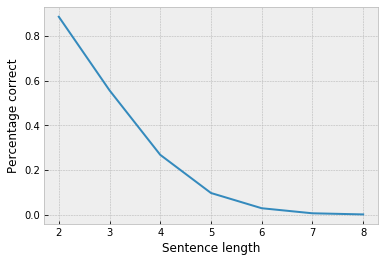

In [62]:
x = sorted(correct.keys())
y = [correct[slen] / total[slen] for slen in x]

plt.xlabel('Sentence length')
plt.ylabel('Percentage correct')
plt.plot(x, y)